<a href="https://colab.research.google.com/github/bcdanl/320-code/blob/main/danl_320_script_20250310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.master("local[*]").getOrCreate()

## UDF, add_dummy_variables

In [ ]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

In [ ]:
dfpd = pd.read_csv('https://bcdanl.github.io/data/NatalRiskData.csv')
dfpd

,PWGT,UPREVIS,CIG_REC,GESTREC3,DPLURAL,ULD_MECO,ULD_PRECIP,ULD_BREECH,URF_DIAB,URF_CHYPER,URF_PHYPER,URF_ECLAM,atRisk,DBWT,ORIGRANDGROUP
0,155,14,0,>= 37 weeks,single,1,0,0,0,0,0,0,0,3714,2
1,140,13,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3715,4
2,151,15,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3447,2
3,118,4,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3175,6
4,134,11,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,4038,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26308,135,11,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3771,9
26309,135,12,0,>= 37 weeks,single,1,0,0,0,0,0,0,0,3210,8
26310,153,11,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3515,5
26311,132,10,0,>= 37 weeks,single,0,0,0,0,0,0,0,0,3147,9


In [ ]:
df = spark.createDataFrame(dfpd)
dtrain, dtest = df.randomSplit([0.5, 0.5], seed = 1234)

In [ ]:
dummy_cols_GESTREC3, ref_category_GESTREC3 = add_dummy_variables('GESTREC3', 1)
dummy_cols_DPLURAL, ref_category_DPLURAL = add_dummy_variables('DPLURAL', 0)

Reference category (dummy omitted): >= 37 weeks
Reference category (dummy omitted): single


In [ ]:
# assembling predictors
x_cols = ['PWGT', 'UPREVIS', 'CIG_REC',
          'ULD_MECO', 'ULD_PRECIP', 'ULD_BREECH', 'URF_DIAB',
          'URF_CHYPER', 'URF_PHYPER', 'URF_ECLAM']

assembler_predictors = (
    x_cols +
    dummy_cols_GESTREC3 + dummy_cols_DPLURAL
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

# training model
model_1 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="atRisk",
                                family="binomial",
                                link="logit")
    .fit(dtrain_1)
)

# making prediction
dtrain_1 = model_1.transform(dtrain_1)
dtest_1 = model_1.transform(dtest_1)

In [ ]:
model_1.summary

Coefficients:
             Feature Estimate Std Error  T Value P Value
         (Intercept)  -4.7385    0.3154 -15.0256  0.0000
                PWGT   0.0029    0.0016   1.8572  0.0633
             UPREVIS  -0.0285    0.0164  -1.7352  0.0827
             CIG_REC   0.3991    0.1965   2.0306  0.0423
            ULD_MECO   1.0701    0.2330   4.5921  0.0000
          ULD_PRECIP   0.4391    0.3564   1.2318  0.2180
          ULD_BREECH   0.3139    0.2193   1.4312  0.1524
            URF_DIAB  -0.0954    0.2874  -0.3320  0.7399
          URF_CHYPER   0.2442    0.4772   0.5117  0.6089
          URF_PHYPER   0.1417    0.2728   0.5196  0.6033
           URF_ECLAM   0.7946    0.7677   1.0350  0.3006
 GESTREC3_<_37_weeks   1.5390    0.1524  10.0977  0.0000
DPLURAL_triplet_o...   1.5956    0.5906   2.7016  0.0069
        DPLURAL_twin   0.5490    0.2400   2.2877  0.0222

(Dispersion parameter for binomial family taken to be 1.0000)
    Null deviance: 2332.2568 on 13108 degrees of freedom
Residual de

In [ ]:
def marginal_effects(model, means):
    """
    Compute marginal effects for all predictors in a PySpark GeneralizedLinearRegression model (logit)
    and return a formatted table with statistical significance.

    Parameters:
        model: Fitted GeneralizedLinearRegression model (with binomial family and logit link).
        means: List of mean values for the predictor variables.

    Returns:
        A formatted string containing the marginal effects table.
    """
    global assembler_predictors  # Use the global assembler_predictors list

    # Extract model coefficients, standard errors, and intercept
    coeffs = np.array(model.coefficients)
    std_errors = np.array(model.summary.coefficientStandardErrors)
    intercept = model.intercept

    # Compute linear combination of means and coefficients (XB)
    XB = np.dot(means, coeffs) + intercept

    # Compute derivative of logistic function (G'(XB))
    G_prime_XB = np.exp(XB) / ((1 + np.exp(XB)) ** 2)

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Create table to store results
    results = []

    for i, predictor in enumerate(assembler_predictors):
        # Compute marginal effect
        marginal_effect = G_prime_XB * coeffs[i]

        # Compute standard error of the marginal effect
        std_error = G_prime_XB * std_errors[i]

        # Compute z-score and p-value
        z_score = marginal_effect / std_error if std_error != 0 else np.nan
        p_value = 2 * (1 - norm.cdf(abs(z_score))) if not np.isnan(z_score) else np.nan

        # Compute confidence interval (95%)
        ci_lower = marginal_effect - 1.96 * std_error
        ci_upper = marginal_effect + 1.96 * std_error

        # Append results
        results.append([predictor, f"{marginal_effect: .4f}", significance_stars(p_value), f"{ci_lower: .4f}", f"{ci_upper: .4f}"])

    # Convert results to tabulated format
    table_str = tabulate(results, headers=["Variable", "Marginal Effect", "Significance", "95% CI Lower", "95% CI Upper"],
                         tablefmt="pretty", colalign=("left", "decimal", "left", "decimal", "decimal"))

    return table_str

# Example usage:
# means = [0.5, 30]  # Mean values for x1 and x2
# assembler_predictors = ['x1', 'x2']  # Define globally before calling the function
# table_output = marginal_effects(fitted_model, means)
# print(table_output)

### Calculating the mean value of each predictor

In [ ]:
# Compute means
means_df = dtrain_1.select([mean(col).alias(col) for col in assembler_predictors])

# Collect the results as a list
means = means_df.collect()[0]
means_list = [means[col] for col in assembler_predictors]

print(means_list)

[153.37219935985368, 11.177107148300564, 0.09061118731900625, 0.04564852918762384, 0.023319615912208505, 0.05989940557841793, 0.05311690291114159, 0.011736015851242189, 0.04343850022862369, 0.0019814052735863436, 0.11469288218259412, 0.0015241579027587258, 0.03208352385307118]


In [ ]:
assembler_predictors

['PWGT',
 'UPREVIS',
 'CIG_REC',
 'ULD_MECO',
 'ULD_PRECIP',
 'ULD_BREECH',
 'URF_DIAB',
 'URF_CHYPER',
 'URF_PHYPER',
 'URF_ECLAM',
 'GESTREC3_<_37_weeks',
 'DPLURAL_triplet_or_higher',
 'DPLURAL_twin']

In [ ]:
table_output = marginal_effects(model_1, means_list)
print(table_output)

+---------------------------+-----------------+--------------+--------------+--------------+
| Variable                  | Marginal Effect | Significance | 95% CI Lower | 95% CI Upper |
+---------------------------+-----------------+--------------+--------------+--------------+
| PWGT                      |          0.0000 | *            |      -0.0000 |       0.0001 |
| UPREVIS                   |         -0.0004 | *            |      -0.0008 |       0.0000 |
| CIG_REC                   |          0.0053 | **           |       0.0002 |       0.0104 |
| ULD_MECO                  |          0.0142 | ***          |       0.0082 |       0.0203 |
| ULD_PRECIP                |          0.0058 |              |      -0.0035 |       0.0151 |
| ULD_BREECH                |          0.0042 |              |      -0.0015 |       0.0099 |
| URF_DIAB                  |         -0.0013 |              |      -0.0088 |       0.0062 |
| URF_CHYPER                |          0.0033 |              |      -0

# Classifier Threshold - Double Density Plot

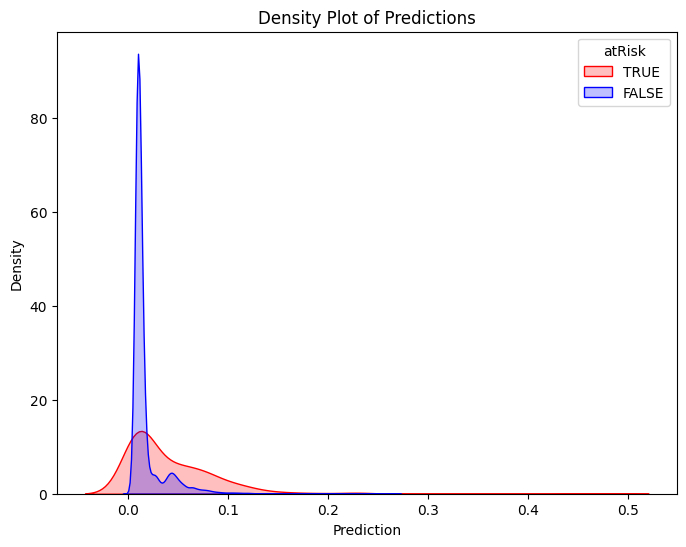

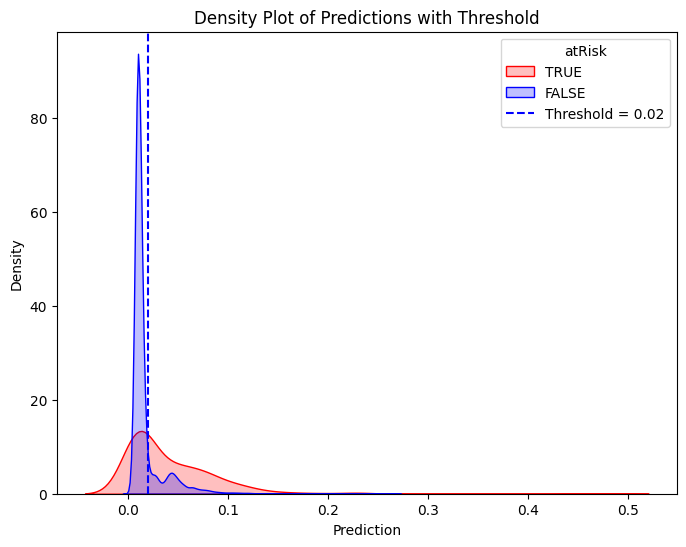

In [ ]:
# Filter training data for atRisk == 1 and atRisk == 0
pdf = dtrain_1.select("prediction", "atRisk").toPandas()

train_true = pdf[pdf["atRisk"] == 1]
train_false = pdf[pdf["atRisk"] == 0]

# Create the first density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(train_true["prediction"], label="TRUE", color="red", fill=True)
sns.kdeplot(train_false["prediction"], label="FALSE", color="blue", fill=True)
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Density Plot of Predictions")
plt.legend(title="atRisk")
plt.show()

# Define threshold for vertical line
threshold = 0.02  # Replace with actual value

# Create the second density plot with vertical line
plt.figure(figsize=(8, 6))
sns.kdeplot(train_true["prediction"], label="TRUE", color="red", fill=True)
sns.kdeplot(train_false["prediction"], label="FALSE", color="blue", fill=True)
plt.axvline(x=threshold, color="blue", linestyle="dashed", label=f"Threshold = {threshold}")
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Density Plot of Predictions with Threshold")
plt.legend(title="atRisk")
plt.show()

# Confusion Matrix

In [ ]:
# Compute confusion matrix
dtest_1 = dtest_1.withColumn("predicted_class", when(col("prediction") > .02, 1).otherwise(0))
conf_matrix = dtest_1.groupBy("atRisk", "predicted_class").count().orderBy("atRisk", "predicted_class")

# Collect as a dictionary for easy lookup
conf_dict = {(row["atRisk"], row["predicted_class"]): row["count"] for row in conf_matrix.collect()}

# Extract values safely (handle missing values if any)
TN = conf_dict.get((0, 0), 0)  # True Negative
FP = conf_dict.get((0, 1), 0)  # False Positive
FN = conf_dict.get((1, 0), 0)  # False Negative
TP = conf_dict.get((1, 1), 0)  # True Positive

# Print formatted confusion matrix with labels
print("\n Confusion Matrix:\n")
print("                     Predicted")
print("            |  Negative  |  Positive  ")
print("------------+------------+------------")
print(f"Actual Neg. |    {TN:5}   |    {FP:5}  |")
print("------------+------------+------------")
print(f"Actual Pos. |    {FN:5}   |    {TP:5}  |")
print("------------+------------+------------")


 Confusion Matrix:

                     Predicted
            |  Negative  |  Positive  
------------+------------+------------
Actual Neg. |    10774   |     2167  |
------------+------------+------------
Actual Pos. |      120   |      130  |
------------+------------+------------
